<a href="https://colab.research.google.com/github/MahdieRah/protein-stability-ml/blob/main/protein_stability_prediction_esm2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup & Install Dependencies

In [ ]:
!pip install biopython fair-esm pandas scikit-learn matplotlib

import pandas as pd
import numpy as np
import os
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.manifold import TSNE


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.1 MB/s eta 0:00:00


Load a Sample of ProTherm Mutations

In [ ]:
wt_seq = "MRLLVLAALLTVGAGQAGLNSRALWQFNGMIKCKIPSSEPLLDFNNYGCYCGLGGSGTPVDDARDRCCFVHDCCYDRGVLTKVGCGVAGTPEQLKAVVSLGSRPCAVNGQYIRVDNRGCNLFLVQNNKTTYNKNYRFLSSSRCR"

data = [
    {"MUTATION": "K 32 E", "ddG": 0.40},
    {"MUTATION": "Y 91 A", "ddG": -5.30},
    {"MUTATION": "Y 91 G", "ddG": -6.70},
    {"MUTATION": "M 1 A", "ddG": -0.10},
    {"MUTATION": "T 105 V", "ddG": -2.14}
]
mutant_df = pd.DataFrame(data)

def apply_mutation(wt_sequence, mutation_str):
    parts = mutation_str.split()
    if len(parts) != 3:
        return None
    orig_aa, pos, new_aa = parts
    pos = int(pos) - 1
    if pos < 0 or pos >= len(wt_sequence):
        return None
    return wt_sequence[:pos] + new_aa + wt_sequence[pos + 1:]

mutant_df["mutated_sequence"] = mutant_df["MUTATION"].apply(lambda x: apply_mutation(wt_seq, x))


Save to FASTA for ESM-2

In [ ]:
records = [SeqRecord(Seq(wt_seq), id="WT", description="wild-type")]

for i, row in mutant_df.iterrows():
    records.append(SeqRecord(Seq(row["mutated_sequence"]), id=row["MUTATION"], description=f"ddG={row['ddG']}"))

SeqIO.write(records, "mutants.fasta", "fasta")


6

Generate ESM-2 Embeddings

In [ ]:
import torch
import esm

model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()

# Load sequences
data = list(SeqIO.parse("mutants.fasta", "fasta"))
labels, sequences = zip(*[(record.id, str(record.seq)) for record in data])
batch_labels, batch_strs, batch_tokens = batch_converter(list(zip(labels, sequences)))

with torch.no_grad():
    results = model(batch_tokens, repr_layers=[6], return_contacts=False)
token_representations = results["representations"][6]

# Average per-sequence embeddings
embeddings = []
for i, (_, seq) in enumerate(zip(labels, sequences)):
    start = 1
    end = start + len(seq)
    emb = token_representations[i, start:end].mean(0).numpy()
    embeddings.append(emb)

# Save embeddings
embedding_df = pd.DataFrame(embeddings)
embedding_df["MUTATION"] = labels
embedding_df["ddG"] = [0.0] + list(mutant_df["ddG"])  # WT ddG = 0
embedding_df.to_csv("esm_embeddings.csv", index=False)


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D-contact-regression.pt


Train ML Model for ddG Prediction

In [ ]:
df = pd.read_csv("esm_embeddings.csv")
df_no_wt = df[df["MUTATION"] != "WT"]

X = df_no_wt.drop(columns=["MUTATION", "ddG"])
y = df_no_wt["ddG"]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

y_pred = model.predict(X)
print("R2 Score:", r2_score(y, y_pred))
print("MSE:", mean_squared_error(y, y_pred))


R2 Score: 0.8670593995811318
MSE: 1.048116455999998


Visualize with t-SNE

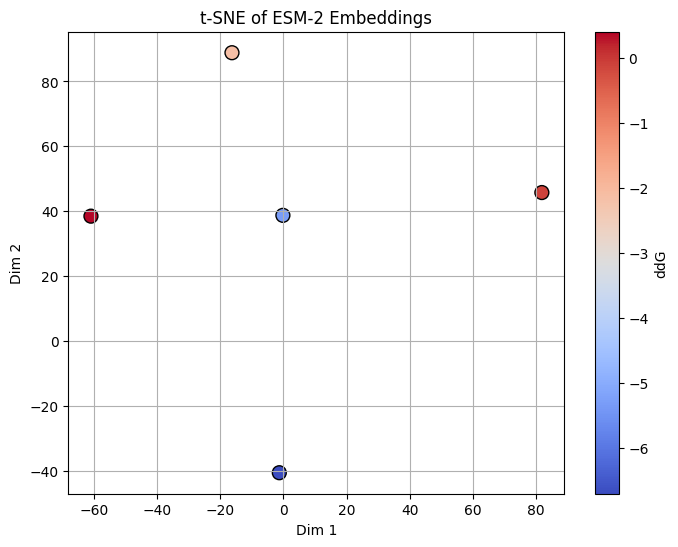

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ✅ Fix: Use perplexity < number of samples (e.g., 2 for 5 points)
tsne = TSNE(n_components=2, perplexity=2, random_state=42)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap="coolwarm", s=100, edgecolor="k")
plt.colorbar(scatter, label="ddG")
plt.title("t-SNE of ESM-2 Embeddings")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()



In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assuming your embeddings DataFrame is called `embedding_df`
# and contains columns 0 to 1279 for ESM-2 embeddings,
# and columns "MUTATION" and "ddG"

# Step 1: Prepare data
X = embedding_df.iloc[:, :1280].values  # ESM-2 embeddings
y = embedding_df["ddG"].values          # ddG values for coloring
labels = embedding_df["MUTATION"].values  # mutation labels for annotation

# Step 2: Run PCA
pca = PCA(n_components=2)
X_2d_pca = pca.fit_transform(X)

# Step 3: Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_2d_pca[:, 0], X_2d_pca[:, 1], c=y, cmap="coolwarm", s=200, edgecolor="k")

# Annotate each point with mutation label
for i, label in enumerate(labels):
    plt.annotate(label, (X_2d_pca[i, 0] + 0.5, X_2d_pca[i, 1]), fontsize=12)

plt.colorbar(scatter, label="ddG")
plt.title("PCA of ESM-2 Embeddings with Mutation Labels")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.tight_layout()
plt.savefig("pca_embeddings_plot.png")
plt.show()


ValueError: could not convert string to float: 'WT'

In [ ]:
# Ensure embedding_df exists and has 1280 float columns for embeddings
embedding_cols = [col for col in embedding_df.columns if isinstance(col, int)]
X = embedding_df[embedding_cols].values.astype(float)


In [ ]:
y = embedding_df["ddG"].values
labels = embedding_df["MUTATION"].values


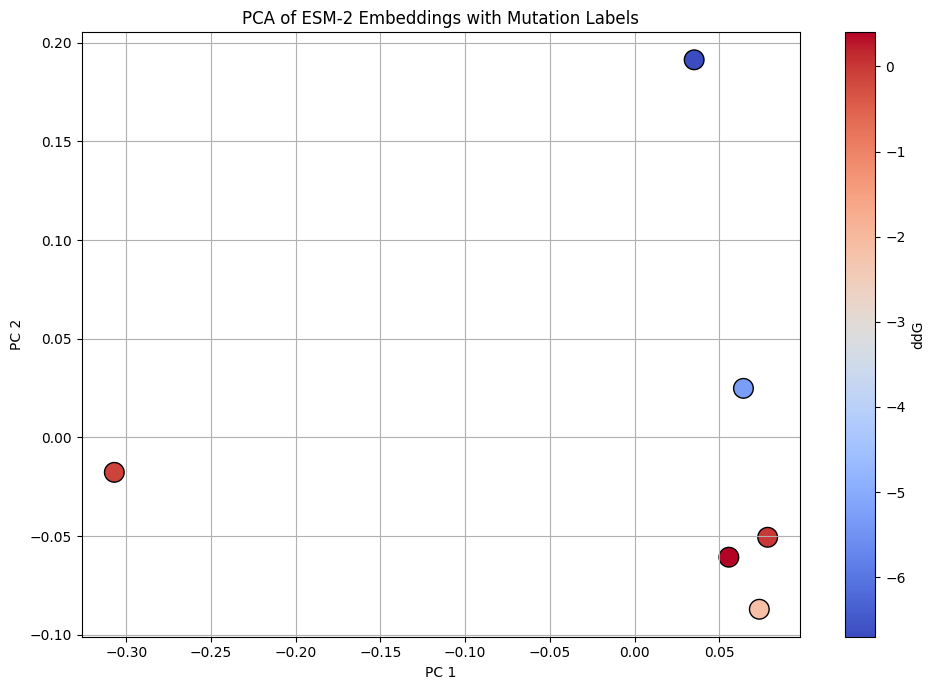

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Run PCA
pca = PCA(n_components=2)
X_2d_pca = pca.fit_transform(X)

# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_2d_pca[:, 0], X_2d_pca[:, 1], c=y, cmap="coolwarm", s=200, edgecolor="k")

# Annotate each point with mutation label
for i, label in enumerate(labels):
    plt.annotate(label, (X_2d_pca[i, 0] + 0.5, X_2d_pca[i, 1]), fontsize=12)

plt.colorbar(scatter, label="ddG")
plt.title("PCA of ESM-2 Embeddings with Mutation Labels")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.tight_layout()
plt.savefig("pca_embeddings_plot.png")
plt.show()
